IMPORTING REQUIREMENTS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
nlp = spacy.load("en_core_web_sm")


LOADING DATA

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()


(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


DATA MISSING VALUES AND FILLING THEM

In [3]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
# Fill missing keyword with empty string
df['keyword'].fillna('', inplace=True)

# Drop location column (optional, safe)
df.drop('location', axis=1, inplace=True)


C:\Users\Dell\AppData\Local\Temp\ipykernel_6584\3426354020.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['keyword'].fillna('', inplace=True)


In [5]:
df.isnull().sum()

id         0
keyword    0
text       0
target     0
dtype: int64

In [6]:
df.head()

,id,keyword,text,target
0,1,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,Forest fire near La Ronge Sask. Canada,1
2,5,,All residents asked to 'shelter in place' are ...,1
3,6,,"13,000 people receive #wildfires evacuation or...",1
4,7,,Just got sent this photo from Ruby #Alaska as ...,1


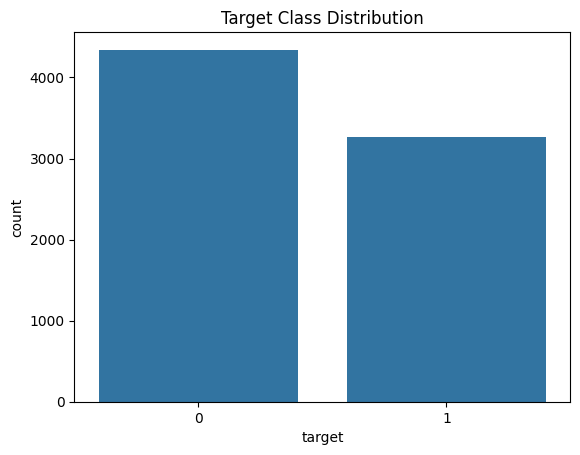

In [7]:
sns.countplot(x='target', data=df)
plt.title("Target Class Distribution")
plt.show()

SPACY PRE PROCESSING-
LOWERCASING, REMOVING URLS, REMOVING PUNCTUATION AND NUMBERS, REMOVING EXTRA SPACES, TOKENIZATION, STEMMING, LEMMATIZATION AND REJOINING

In [8]:
def spacy_preprocess(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Remove special chars and digits
    doc = nlp(text.lower().strip())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return tokens

df["tokens"] = df["text"].apply(spacy_preprocess)
df[["text", "tokens"]].head()


,text,tokens
0,Our Deeds are the Reason of this #earthquake M...,"[deed, reason, earthquake, allah, forgive]"
1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,"[resident, ask, shelter, place, notify, office..."
3,"13,000 people receive #wildfires evacuation or...","[people, receive, wildfire, evacuation, order,..."
4,Just got sent this photo from Ruby #Alaska as ...,"[get, send, photo, ruby, alaska, smoke, wildfi..."


WORDCLOUD FOR REAL AND FAKE TWEETS

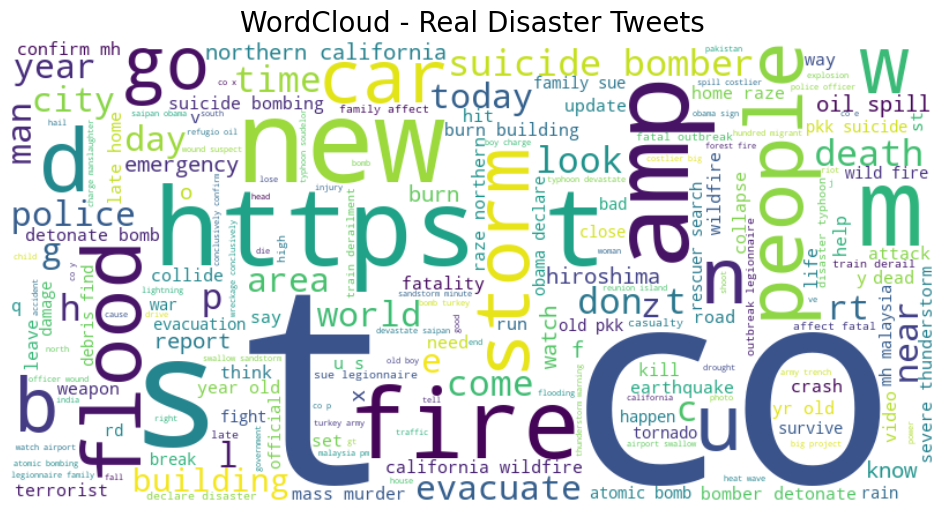

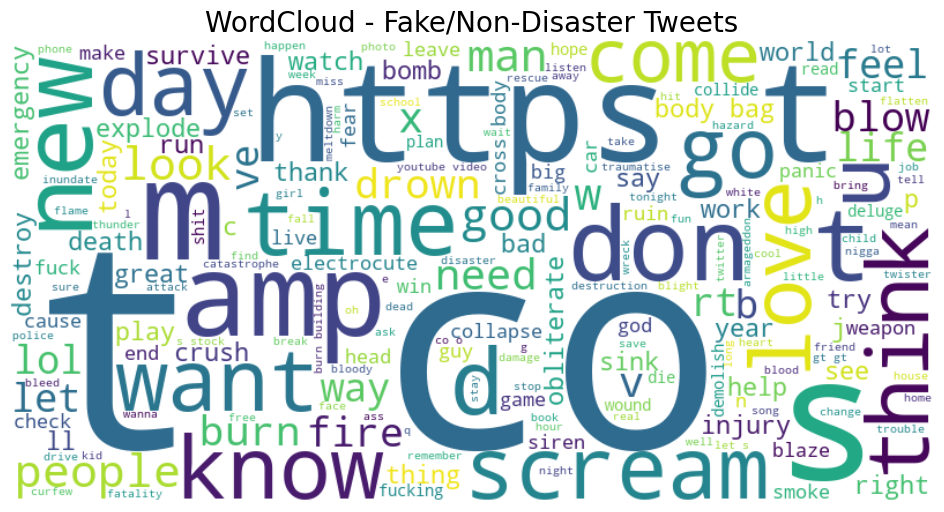

In [9]:
from wordcloud import WordCloud

def show_wordcloud(text_list, title):
    text_combined = " ".join([" ".join(tokens) for tokens in text_list])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

# WordCloud for real disaster tweets
show_wordcloud(df[df['target'] == 1]['tokens'], "WordCloud - Real Disaster Tweets")

# WordCloud for fake/non-disaster tweets
show_wordcloud(df[df['target'] == 0]['tokens'], "WordCloud - Fake/Non-Disaster Tweets")


FEATURE EXTRACTION- BAG OF WORDS

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Join tokens into string format for vectorization
df['text_joined'] = df['tokens'].apply(lambda x: " ".join(x))

vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['text_joined'])

print("Shape of BOW matrix:", X_bow.shape)

Shape of BOW matrix: (7613, 19696)


FEATURE EXTRACTION- TF-IDF VECTORIZATION

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform on the joined tokenized text
X_tfidf = tfidf_vectorizer.fit_transform(df['text_joined'])

print("✅ Shape of TF-IDF matrix:", X_tfidf.shape)


✅ Shape of TF-IDF matrix: (7613, 5000)


TRAIN WORD2VEC-- AND CAN CONTINUE FOR ADVANCED SEMANTIC MODELS (E.G., LSTM, TRANSFORMERS, or DEEP MLPs).

In [14]:
from gensim.models import Word2Vec

# Input should be a list of lists of tokens (already present as df['tokens'])
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
w2v_model.train(df['tokens'], total_examples=len(df['tokens']), epochs=10)


(778676, 912750)

In [15]:
import numpy as np

def get_avg_w2v(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

X_w2v = np.array([get_avg_w2v(tokens, w2v_model, 100) for tokens in df['tokens']])

print("Shape of Word2Vec feature matrix:", X_w2v.shape)


Shape of Word2Vec feature matrix: (7613, 100)


PATH 1: TF-IDF

TEST TRAIN SPLIT-

In [16]:
from sklearn.model_selection import train_test_split

y = df['target']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print("✅ Train shape:", X_train_tfidf.shape)
print("✅ Test shape:", X_test_tfidf.shape)


✅ Train shape: (6090, 5000)
✅ Test shape: (1523, 5000)


HELPER FUNCTION TO EVALUATE MODELS

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Print text metrics
    print(f"🎯 {model.__class__.__name__} Results")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Disaster', 'Disaster'],
                yticklabels=['Not Disaster', 'Disaster'])
    plt.title(f"{model.__class__.__name__} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "-"*60 + "\n")


TRAINING THE MODELS: LOGISTIC REGRESSION, SVM, NAIVE BAIYES

🎯 LogisticRegression Results
Accuracy: 0.7944845699277742
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.81      0.68      0.74       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



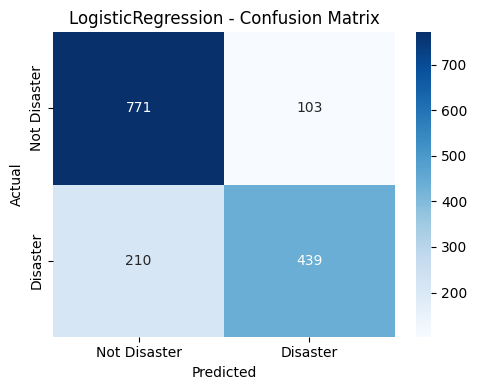


------------------------------------------------------------

🎯 MultinomialNB Results
Accuracy: 0.7977675640183848
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.81      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



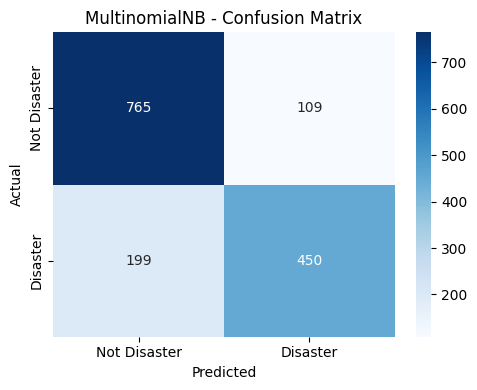


------------------------------------------------------------

🎯 LinearSVC Results
Accuracy: 0.7826657912015759
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       874
           1       0.76      0.71      0.74       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



c:\Users\Dell\python\FakeNews\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


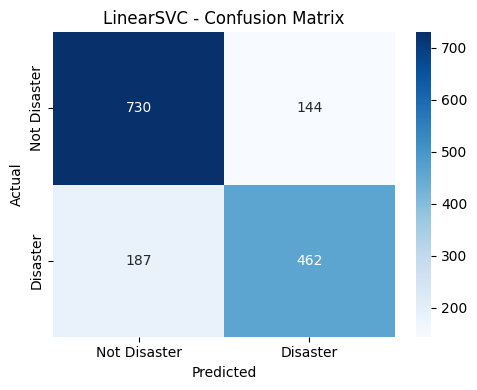


------------------------------------------------------------



In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Logistic Regression
train_and_evaluate_model(LogisticRegression(max_iter=1000), X_train_tfidf, y_train, X_test_tfidf, y_test)

# Multinomial Naive Bayes
train_and_evaluate_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)

# Support Vector Machine (Linear Kernel)
train_and_evaluate_model(LinearSVC(), X_train_tfidf, y_train, X_test_tfidf, y_test)


PATH 2: WORD2VEC

PREPARE TOKENS 

TRAIN WORD2VEC

In [22]:
from gensim.models import Word2Vec

# make sure tokenized_tweets is a list of lists of strings
tokenized_tweets = df['tokens'].tolist()

w2v_model = Word2Vec(
    sentences=tokenized_tweets,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    seed=42
)


AVERAGING WORD EMBEDDINGS PER TWEET

In [23]:
import numpy as np

def get_avg_word2vec(tokens, model, k=100):
    vec = np.zeros(k)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec

X_w2v = np.array([get_avg_word2vec(tweet, w2v_model, k=100) for tweet in tokenized_tweets])


TEST TRAIN SPLIT

In [24]:
from sklearn.model_selection import train_test_split

X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)

TRAINING MODELS: (NOT COMPATIBLE WITH NAIVE BAYES)

In [25]:
from sklearn.linear_model import LogisticRegression

lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_w2v_train, y_w2v_train)


LogisticRegression(max_iter=1000)

In [26]:
from sklearn.svm import SVC

svm_w2v = SVC(kernel='linear')
svm_w2v.fit(X_w2v_train, y_w2v_train)


SVC(kernel='linear')

EVALUATE FUNCTION

🎯 LogisticRegression Results
Accuracy: 0.6080105055810899
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.80      0.70       869
           1       0.57      0.36      0.44       654

    accuracy                           0.61      1523
   macro avg       0.60      0.58      0.57      1523
weighted avg       0.60      0.61      0.59      1523



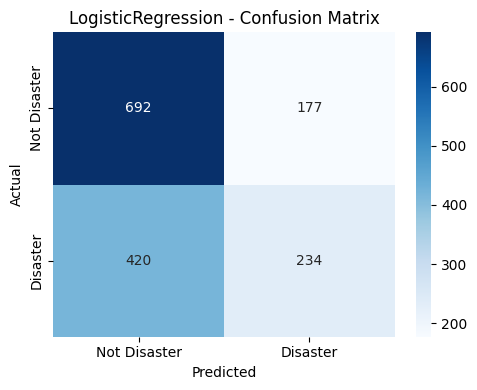


------------------------------------------------------------

🎯 SVC Results
Accuracy: 0.6296782665791202
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.70      0.68       869
           1       0.57      0.54      0.56       654

    accuracy                           0.63      1523
   macro avg       0.62      0.62      0.62      1523
weighted avg       0.63      0.63      0.63      1523



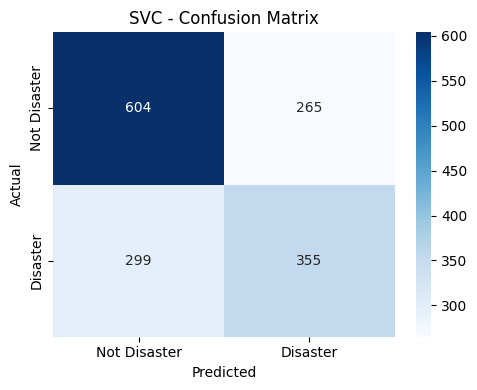


------------------------------------------------------------



In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Logistic Regression on Word2Vec
train_and_evaluate_model(LogisticRegression(max_iter=1000), X_w2v_train, y_w2v_train, X_w2v_test, y_w2v_test)

# SVM on Word2Vec (can try both linear and rbf kernels)
train_and_evaluate_model(SVC(kernel='linear'), X_w2v_train, y_w2v_train, X_w2v_test, y_w2v_test)


THUS, NAIVE BAYES WITH TF-IDF AS VECTORIZER PERFORMED BEST- ACCURACY, PRECISION, RECALL, F1-SCORE

WORD2VEC DID NOT PERFORM WELL AS IT REQUIRES LARGER DATASET THAN WHAT WE HAVE RIGHT NOW (7-8k), WORKS BEST ON MILLIONS OF CASES

HYPER-PARAMETER TUNING

1.  TFIDF- LOGISTIC REGRESSION GRID SEARCH

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for Logistic Regression: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
🎯 LogisticRegression Results
Accuracy: 0.7944845699277742
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.81      0.68      0.74       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



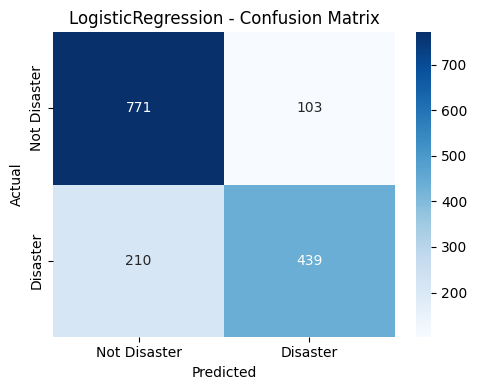


------------------------------------------------------------



In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # 'l1' works with saga solver
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
}

grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_lr.fit(X_train_tfidf, y_train)

print("Best Parameters for Logistic Regression:", grid_lr.best_params_)
best_lr_tfidf = grid_lr.best_estimator_

# Evaluate
train_and_evaluate_model(best_lr_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)


2. TFIDF- NAIVE BAYES GRID SEARCH

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Naive Bayes: {'alpha': 2.0, 'fit_prior': False}
🎯 MultinomialNB Results
Accuracy: 0.7879185817465528
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       874
           1       0.75      0.75      0.75       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



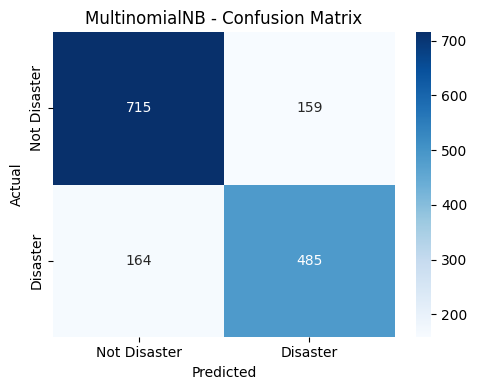


------------------------------------------------------------



In [35]:
from sklearn.naive_bayes import MultinomialNB

param_grid_nb = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_nb.fit(X_train_tfidf, y_train)

print("Best Parameters for Naive Bayes:", grid_nb.best_params_)
best_nb_tfidf = grid_nb.best_estimator_

# Evaluate
train_and_evaluate_model(best_nb_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)


3. TFIDF- LINEAR SVM GRID SEARCH

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Linear SVM: {'C': 0.1, 'max_iter': 1000}
🎯 LinearSVC Results
Accuracy: 0.7931713722915299
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       874
           1       0.81      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



c:\Users\Dell\python\FakeNews\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Dell\python\FakeNews\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


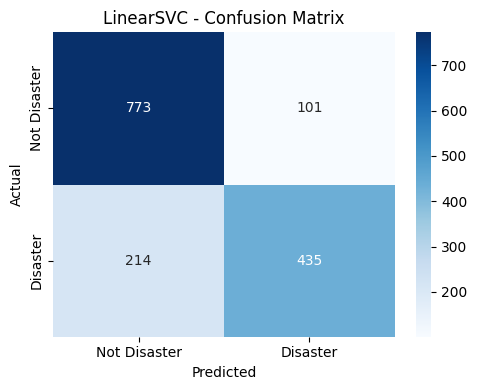


------------------------------------------------------------



In [36]:
from sklearn.svm import LinearSVC

param_grid_svc = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [1000, 2000]
}

grid_svc = GridSearchCV(LinearSVC(), param_grid_svc, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_svc.fit(X_train_tfidf, y_train)

print("Best Parameters for Linear SVM:", grid_svc.best_params_)
best_svc_tfidf = grid_svc.best_estimator_

# Evaluate
train_and_evaluate_model(best_svc_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)


4. WORD2VEC LOGISTIC REGRESSION GRID SEARCH

Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best LogisticRegression Params (Word2Vec): {'C': 10, 'max_iter': 1000, 'solver': 'saga'}
🎯 LogisticRegression Results
Accuracy: 0.6579120157583717
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.81      0.73       869
           1       0.64      0.45      0.53       654

    accuracy                           0.66      1523
   macro avg       0.65      0.63      0.63      1523
weighted avg       0.66      0.66      0.65      1523



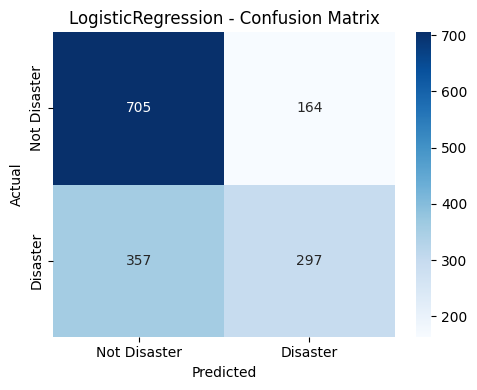


------------------------------------------------------------



In [37]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
}

grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_lr.fit(X_w2v_train, y_w2v_train)

print("✅ Best LogisticRegression Params (Word2Vec):", grid_lr.best_params_)

# Train with best estimator
best_lr_w2v = grid_lr.best_estimator_
train_and_evaluate_model(best_lr_w2v, X_w2v_train, y_w2v_train, X_w2v_test, y_w2v_test)


5. WORD2VEC SVM GRID SEARCH

c:\Users\Dell\python\FakeNews\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Dell\python\FakeNews\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Dell\python\FakeNews\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Dell\python\FakeNews\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


🎯 LinearSVC Results
Accuracy: 0.6946815495732108
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.82      0.75       869
           1       0.69      0.53      0.60       654

    accuracy                           0.69      1523
   macro avg       0.69      0.67      0.68      1523
weighted avg       0.69      0.69      0.69      1523



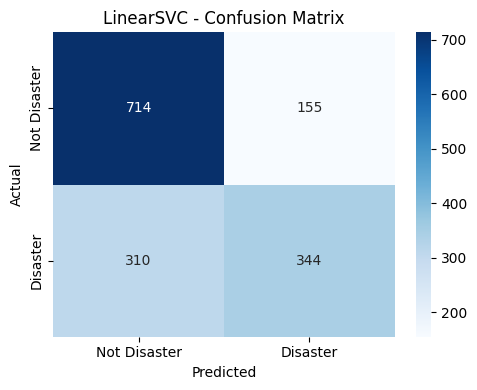


------------------------------------------------------------



In [38]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1.0, 10.0],
    'max_iter': [1000, 2000]
}

grid = GridSearchCV(LinearSVC(), param_grid, cv=3, n_jobs=-1)
grid.fit(X_w2v_train, y_w2v_train)

# Evaluate the best model
best_svc_w2v= grid.best_estimator_
train_and_evaluate_model(best_svc_w2v, X_w2v_train, y_w2v_train, X_w2v_test, y_w2v_test)


COMPARISON--

| Model               | Vectorizer | Accuracy
| ------------------- | ---------- | --------
| Logistic Regression | TF-IDF     | 0.794   
| MultinomialNB       | TF-IDF     | 0.798   
| LinearSVC           | TF-IDF     | 0.793   
| Logistic Regression | Word2Vec   | 0.658   
| LinearSVC           | Word2Vec   | 0.695   

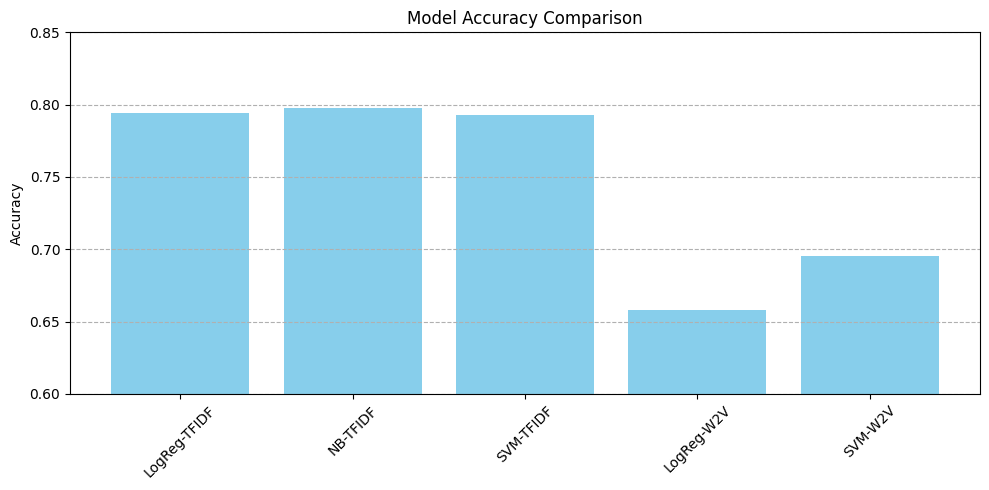

In [33]:
import matplotlib.pyplot as plt

models = [
    'LogReg-TFIDF', 'NB-TFIDF', 'SVM-TFIDF',
    'LogReg-W2V', 'SVM-W2V'
]
accuracies = [
    0.794, 0.798, 0.793,
    0.658, 0.695
]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color='skyblue')
plt.ylim(0.6, 0.85)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


✅ TF-IDF PERFORMS BEST ACROSS ALL MODELS
✅ MULTINOMIAL NAIVE BAYES WITH TF-IDF IS THE MOST ACCURATE (~79.8%).
✅ WORD2VEC UNDERPERFORMS, LIKELY DUE TO SMALL DATA SIZE- MAY IMPROVE WITH BETTER EMBEDDINGS LIKE BERT

ROC AND PR CURVES--

In [39]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

def plot_roc_pr_curves(model, X_test, y_test, label="Model"):
    # Get predicted probabilities or decision scores
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError("Model does not have predict_proba or decision_function method")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    # Plot both ROC and PR in subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    axs[0].plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
    axs[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
    axs[0].set_title("ROC Curve")
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].legend()

    # PR Curve
    axs[1].plot(recall, precision, label=label)
    axs[1].set_title("Precision-Recall Curve")
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


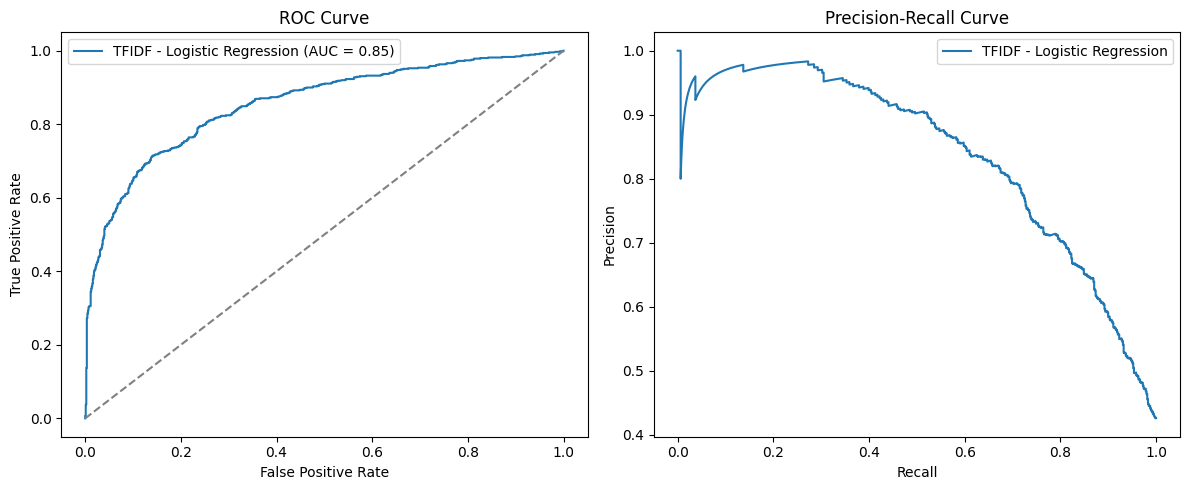

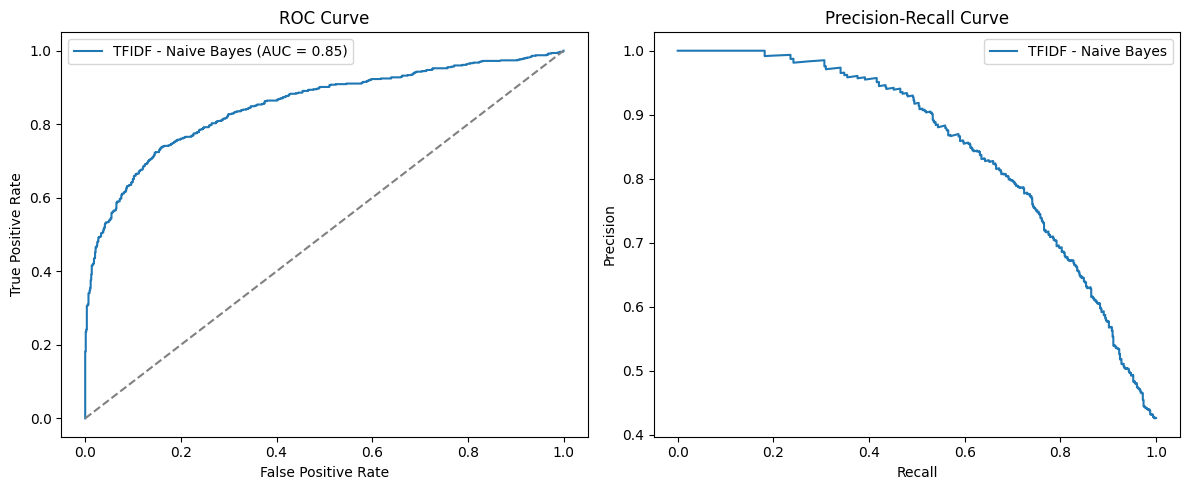

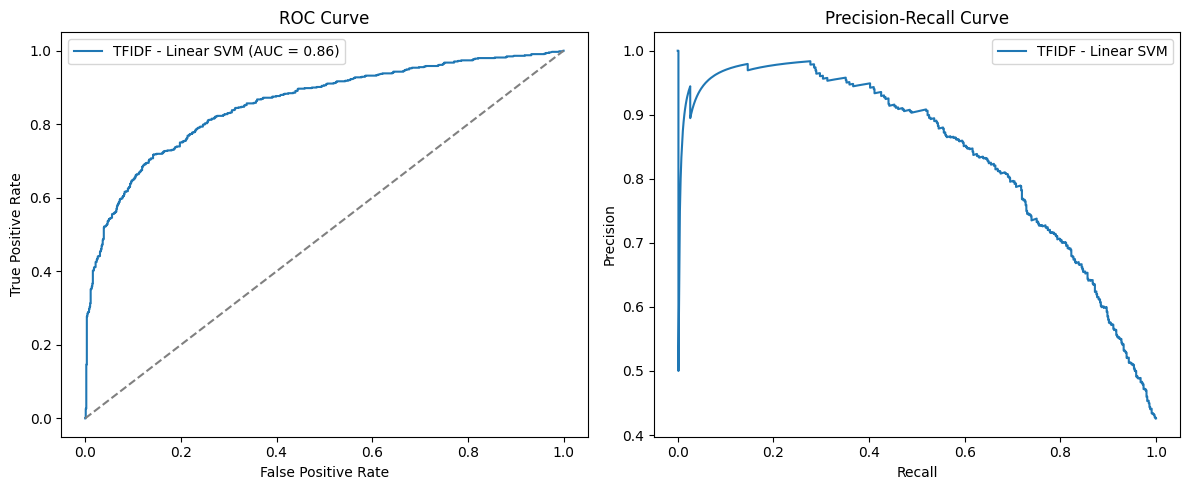

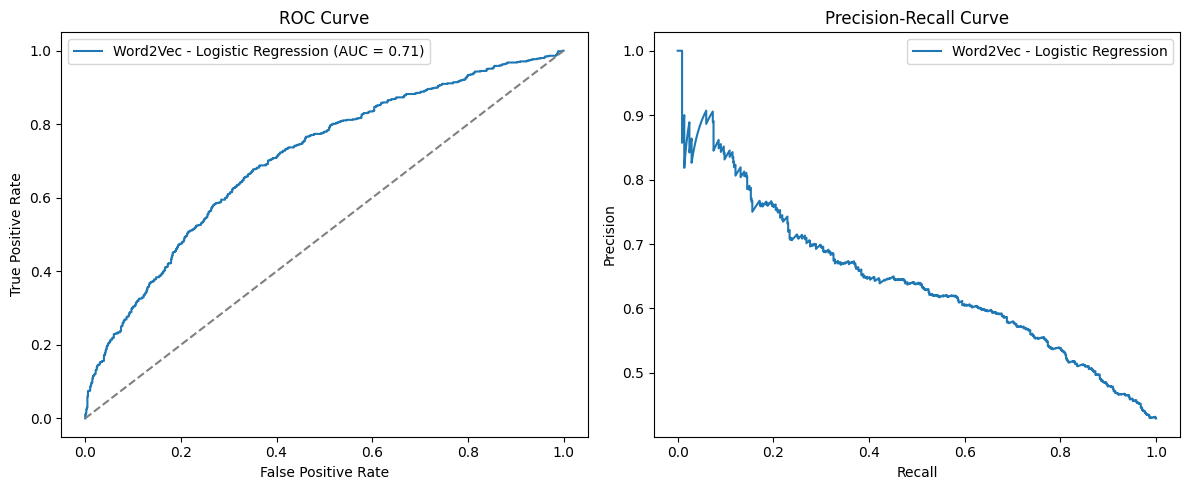

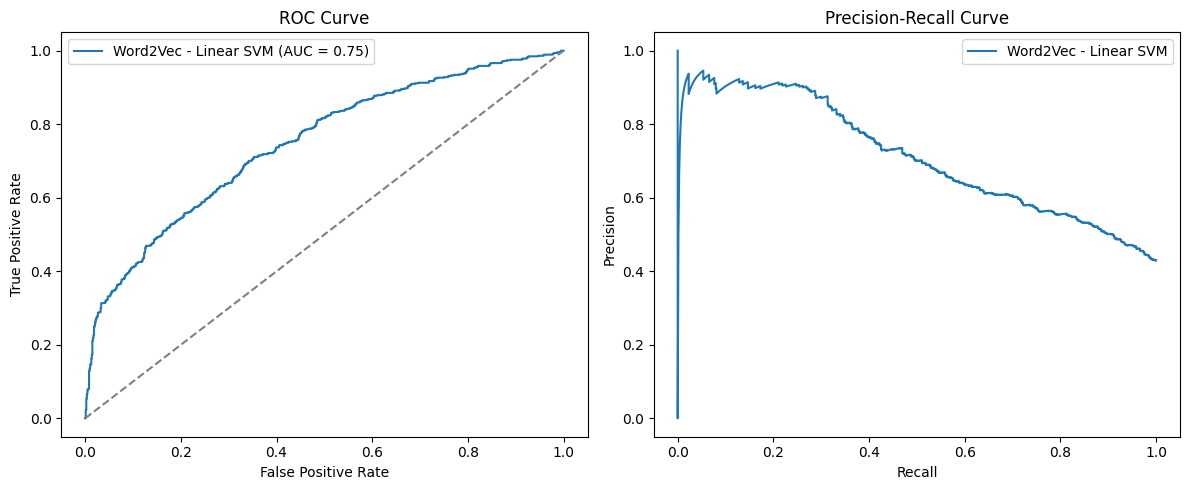

In [40]:
# TF-IDF Models
plot_roc_pr_curves(best_lr_tfidf, X_test_tfidf, y_test, label="TFIDF - Logistic Regression")
plot_roc_pr_curves(best_nb_tfidf, X_test_tfidf, y_test, label="TFIDF - Naive Bayes")
plot_roc_pr_curves(best_svc_tfidf, X_test_tfidf, y_test, label="TFIDF - Linear SVM")

# Word2Vec Models
plot_roc_pr_curves(best_lr_w2v, X_w2v_test, y_w2v_test, label="Word2Vec - Logistic Regression")
plot_roc_pr_curves(best_svc_w2v, X_w2v_test, y_w2v_test, label="Word2Vec - Linear SVM")


| Model                   | Vectorizer | AUC (ROC) | PR Curve Behavior        | Inference                  |
| ----------------------- | ---------- | --------- | ------------------------ | -------------------------- |
| Logistic Regression     | TF-IDF     |   0.85    | Good, balanced PR curve  | Strong classifier          |
| Naive Bayes             | TF-IDF     |   0.85    | Slightly more steep drop | Still very strong          |
| Linear SVM              | TF-IDF     |   0.86    | Best PR curve            | Best overall performer     |
| Logistic Regression     | Word2Vec   |   0.71    | Lower precision & recall | Weaker                     |
| Linear SVM              | Word2Vec   |   0.75    | Some improvement         | Still not great            |


TF-IDF > WORD2VEC for your dataset and models.
Likely because TF-IDF captures sparse important word info better in this binary classification.

Linear SVM (TF-IDF) is the best performing model overall.
Highest AUC and smooth PR curve.

Word2Vec models underperform...

CONFUSION MATRIX--

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrices(model_list, X_list, y_list, titles, figsize=(18, 10)):
    cols = 2
    rows = (len(model_list) + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for idx, (model, X, y, title) in enumerate(zip(model_list, X_list, y_list, titles)):
        y_pred = model.predict(X)
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
        axes[idx].set_title(title)

    # Hide unused subplots if any
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


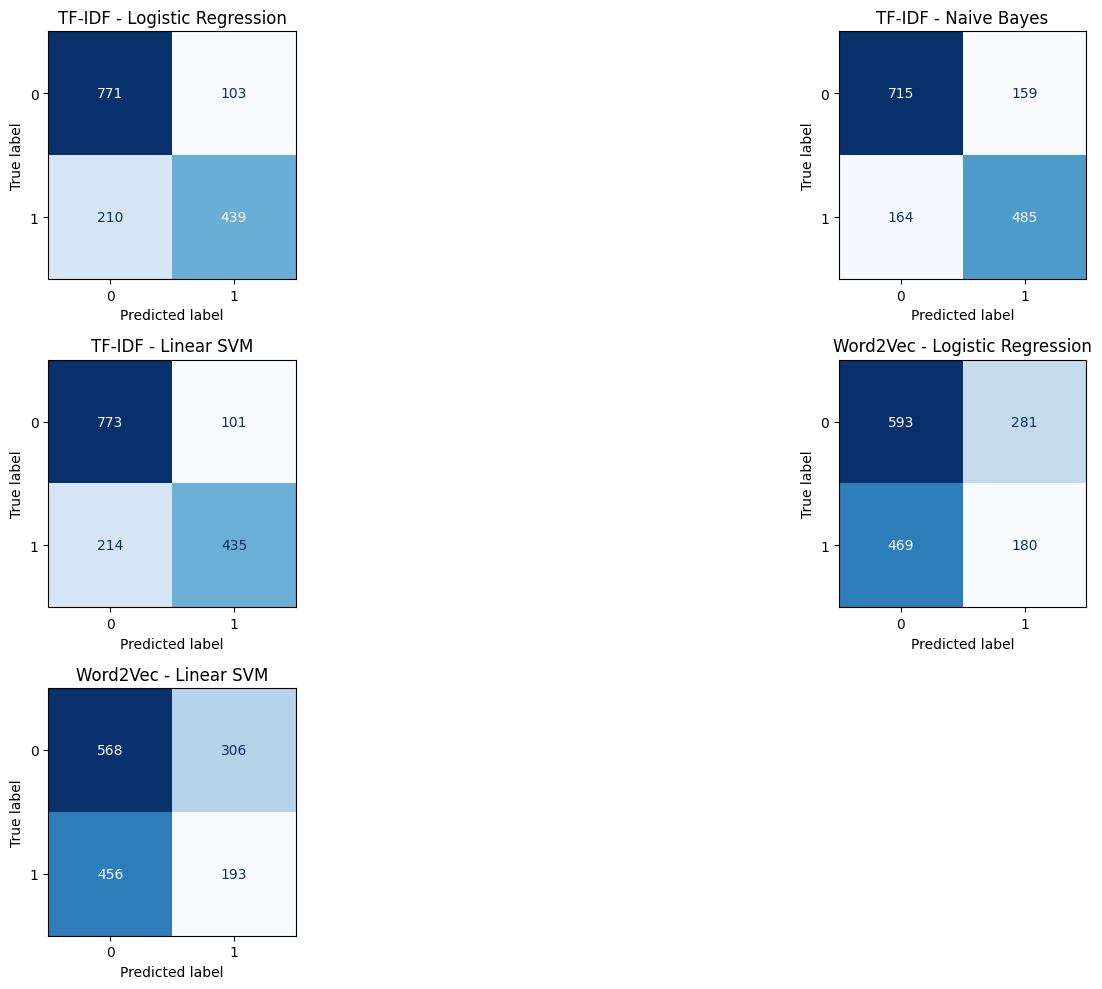

In [44]:
models = [best_lr_tfidf, best_nb_tfidf, best_svc_tfidf, best_lr_w2v, best_svc_w2v]
X_inputs = [X_test_tfidf, X_test_tfidf, X_test_tfidf, X_w2v_test, X_w2v_test]
y_inputs = [y_test] * 5
titles = [
    "TF-IDF - Logistic Regression",
    "TF-IDF - Naive Bayes",
    "TF-IDF - Linear SVM",
    "Word2Vec - Logistic Regression",
    "Word2Vec - Linear SVM"
]

plot_confusion_matrices(models, X_inputs, y_inputs, titles)


MISCLASSIFCATION:

In [47]:
import numpy as np

def get_misclassified_examples(model, X_test, y_test, original_df, n=10):
    """
    Print misclassified tweets with true vs predicted labels.
    """
    y_pred = model.predict(X_test)
    
    # Convert to arrays for comparison
    y_test_arr = y_test.values
    misclassified_indices = np.where(y_pred != y_test_arr)[0]
    
    print(f"❌ Total Misclassified: {len(misclassified_indices)}")

    for idx in misclassified_indices[:n]:
        tweet_text = original_df.iloc[y_test.index[idx]]['text']
        print(f"\n🔹 Tweet: {tweet_text}")
        print(f"➡️  True: {y_test_arr[idx]} | Predicted: {y_pred[idx]}")


In [49]:
print("🔍 TF-IDF Logistic Regression Misclassified Samples")
get_misclassified_examples(best_lr_tfidf, X_test_tfidf, y_test, df)

print("\n🔍 TF-IDF Naive Bayes Misclassified Samples")
get_misclassified_examples(best_nb_tfidf, X_test_tfidf, y_test, df)

print("\n🔍 TF-IDF Linear SVM Misclassified Samples")
get_misclassified_examples(best_svc_tfidf, X_test_tfidf, y_test, df)

print("\n🔍 Word2Vec Logistic Regression Misclassified Samples")
get_misclassified_examples(best_lr_w2v, X_w2v_test, y_w2v_test, df)

print("\n🔍 Word2Vec Linear SVM Misclassified Samples")
get_misclassified_examples(best_svc_w2v, X_w2v_test, y_w2v_test, df)


🔍 TF-IDF Logistic Regression Misclassified Samples
❌ Total Misclassified: 313

🔹 Tweet: So you have a new weapon that can cause un-imaginable destruction.
➡️  True: 1 | Predicted: 0

🔹 Tweet: my favorite lady came to our volunteer meeting
hopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS
➡️  True: 1 | Predicted: 0

🔹 Tweet: @brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS
➡️  True: 1 | Predicted: 0

🔹 Tweet: Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE
➡️  True: 0 | Predicted: 1

🔹 Tweet: Nepal earthquake 3 months on: Women fear abuse https://t.co/iCTtZ0Divr via @@loupascale
➡️  True: 1 | Predicted: 0

🔹 Tweet: Escape The Heat (and the #ORShow) for a trail run on Desolation Loop you'll be glad you did http://t.co/n2ucNzh38P http://t.co/VU8fWYMw5r
➡️  True: 0 | Predicted: 1

🔹 Tw

OBSERVATION AND POSSIBLE CAUSES:- 

Some tweets use metaphorical or poetic language (e.g., "she's a suicide bomb")
: Model struggles with figurative/non-literal language 

Many misclassifications include links (`http`, `t.co`)                              
: Models may not extract semantic meaning from URLs     

Some fake tweets look very neutral or factual  
: Classifier likely picks up surface-level words, missing context     

Words like bomb, earthquake, explosion in real tweets led to fake predictions 
: Model may be biased toward disaster words (especially if common in fake class)

Misclassified tweets often contain hashtags, mentions           
: These may add noise or distract the model                

In [50]:
import pickle

# Save best model (TF-IDF Logistic Regression)
with open("model/fake_news_model.pkl", "wb") as f:
    pickle.dump(best_lr_tfidf, f)

# Save TF-IDF Vectorizer
with open("model/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
